In [ ]:
import hdf5storage
from helpers import *
from get_data import *
from synchrony import *
import numpy as np


%load_ext autoreload
%autoreload 2


### Loading in the bat data (LFP and positional data)
#### We first need to load in the LFP data, which in this case is stored in a MATLAB file. We can do this using ```hdf5storage```. The bat's positional data is stored in a matlab file (not accessible for public use), but luckily the accessors for this data can be found in ```dataset.py``` thanks to the Yartsev Lab.

In [23]:
data_path = './data'
bat_id = '32622'
date = '231007'
lfp_file_path = './data/ephys/32622_231007_lfp.mat'


#Clean up position data (remove NaNs, etc.) and load in LFP from given file path
lfp_mat, cleaned_pos, session = load_and_clean_bat_data(data_path, bat_id, date, lfp_file_path,use_cache=True)

Structure of lfp_data: <class 'numpy.ndarray'>, (1, 2)
Loading Flight Room | 32622 | 231007 from cache...
Positional data shape: (841160, 3)
Cleaned positional data shape: (841160, 3)


### Time synchronization
#### Before we get to the main attraction (the LFP data), we need to ensure our data is synchronized. To do this, we need to extract global timestamps from both the LFP and positional data and make sure they start at the same time.

In [24]:
lfp_timestamps_edges, binned_pos, pos_timestamps, lfp_indices, valid_indices = sync_and_bin_data(lfp_mat, session,cleaned_pos)

#lfp_timestamp_edges stores edges between timebins. this will be useful for aligning the LFP data with the position data
#binned_pos is the cleaned position averaged over the timebins
#valid_indices is a boolean array that marks the non-negative position timestamps
#pos_timestamps is the cleaned and filtered timestamps of the position data
#lfp_indices is a boolean array that marks the non-negative, decimated LFP timestamps


LFP timestamps structure: (17222917, 1)
Decimated LFP timestamps shape: (172230,)
LFP timestamp edges shape: (170691,)
Positional timestamp diff (microseconds): [8333.33333331 8333.33333334 8333.33333334 ... 8333.33772278 8333.33771515
 8333.33771515]
Cleaned positional data shape: (824435, 3)
Binned positional data shape: (170690, 3)


In [25]:
print("Number of NaN values in binned_pos:", np.isnan(binned_pos).sum())


Number of NaN values in binned_pos: 6


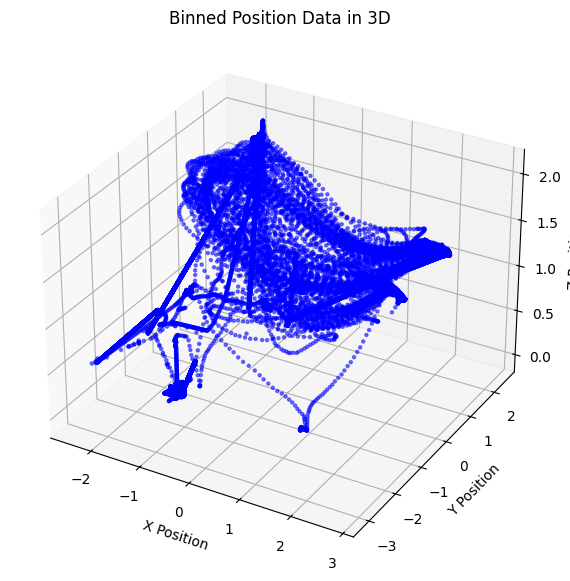

In [26]:
import matplotlib.pyplot as plt

# Assuming binned_position is a 2D array with shape (N, 3) for [X, Y, Z]
x_binned = binned_pos[:, 0]
y_binned = binned_pos[:, 1]

# If binned_position has a Z dimension, use a 3D plot
if binned_pos.shape[1] == 3:
    z_binned = binned_pos[:, 2]
    
    # 3D scatter plot
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_binned, y_binned, z_binned, c='blue', alpha=0.5, s=5)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.set_title('Binned Position Data in 3D')
else:
    # 2D scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_binned, y_binned, c='blue', alpha=0.5, s=5)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Binned Position Data in 2D')

plt.show()


#### Inside of ```lfp_timestamps_edges```, we store the *edges* between timebins. We will use this to later to bin the position data; instead of downsampling the data like we did the LFP, we will average across bins (between two edges) of the LFP timebins to get synchronized data streams.

In [ ]:
print("First few elements of binned_pos:\n", binned_pos[:, :5]) # NaN values at beginning and end are expected; position is not recorded when bat is not visible.

print("First few LFP bins:", lfp_timestamps_edges[:5])

##### Notice above that the LFP timestamp edges have N+1 the shape of the binned position. This makes sense and is expected; `lfp_timestamps_edges` contains the bins (which are stored in groups of two, i.e. the first bin is [0, 4514.4426] and so on) for which the position was binned into.

### Organizing behavioral data
#### To better organize the binned flight data, we need to construct a flightID array which will contain all the binned positions for each flight, accounting for which feeder (or the perch) was visited for each data point entered in that flight.

In [39]:
from get_data import get_flightID

flightID = get_flightID(session, binned_pos, valid_indices, lfp_timestamps_edges, pos_timestamps,off_samples=200) 

In [40]:
# Extract start and end positions
start_positions = []
end_positions = []

for flight_number in np.unique(flightID[:, 0]):
    # Get all data for the current flight
    flight_data = flightID[flightID[:, 0] == flight_number]
    
    # Append start and end positions
    start_positions.append(flight_data[0, 2:5])  # Columns 2, 3, 4 are X, Y, Z positions
    end_positions.append(flight_data[-1, 2:5])   # Last row for end position

# Convert lists to NumPy arrays for clustering
start_positions = np.array(start_positions)
end_positions = np.array(end_positions)

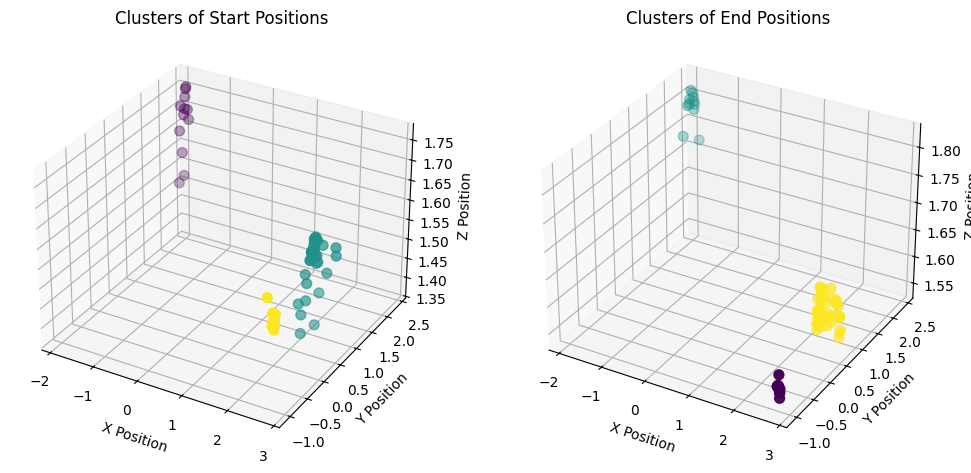

In [41]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming start_positions and end_positions are already created
# Remove rows with NaN values
start_positions = start_positions[~np.isnan(start_positions).any(axis=1)]
end_positions = end_positions[~np.isnan(end_positions).any(axis=1)]

# Number of clusters (adjust based on observation)
num_clusters = 3

# Clustering start positions
start_kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(start_positions)
start_labels = start_kmeans.labels_

# Clustering end positions
end_kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(end_positions)
end_labels = end_kmeans.labels_

# Plot clusters for start positions
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(start_positions[:, 0], start_positions[:, 1], start_positions[:, 2], c=start_labels, cmap='viridis', s=50)
ax.set_title('Clusters of Start Positions')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')

# Plot clusters for end positions
ax = fig.add_subplot(122, projection='3d')
ax.scatter(end_positions[:, 0], end_positions[:, 1], end_positions[:, 2], c=end_labels, cmap='viridis', s=50)
ax.set_title('Clusters of End Positions')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')

plt.show()


In [42]:
import numpy as np

# Assuming flightID[:, 1] contains the flight type codes
flight_types = flightID[:, 1]

# Define a mapping from flight type codes to their descriptions
flight_type_mapping = {
    0: "Other/Unknown",
    1: "Perch to Feeder 1",
    2: "Feeder 1 to Perch",
    3: "Perch to Feeder 2",
    4: "Feeder 2 to Perch",
    5: "Feeder 1 to Feeder 2",
    6: "Feeder 2 to Feeder 1"
}

# Count the occurrences of each unique flight type
unique_types, counts = np.unique(flight_types, return_counts=True)

# Calculate the percentage of each flight type
total_samples = len(flight_types)
percentages = (counts / total_samples) * 100

# Print the percentage of each flight type using their descriptions
print("Percentage of each flight type:")
for flight_type, percentage in zip(unique_types, percentages):
    description = flight_type_mapping.get(int(flight_type), "Unknown")
    print(f"{description}: {percentage:.2f}%")


Percentage of each flight type:
Other/Unknown: 68.35%
Perch to Feeder 1: 11.87%
Feeder 1 to Perch: 10.49%
Perch to Feeder 2: 1.08%
Feeder 2 to Perch: 1.11%
Feeder 1 to Feeder 2: 2.89%
Feeder 2 to Feeder 1: 4.20%


In [ ]:
import matplotlib.pyplot as plt

# Extract positions and classifications
positions = flightID[:, 2:4]  # Assuming columns 2 and 3 contain the x and y positions
classifications = [determine_feeder(pos) for pos in positions]

# Convert classifications to numerical values for plotting
classification_mapping = {'perch': 0, 'feeder1': 1, 'feeder2': 2, 'unknown': 3}
numerical_classifications = [classification_mapping[cls] for cls in classifications]

# Plot the positions with different colors for each classification
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], c=numerical_classifications, cmap='viridis', alpha=0.6)
plt.colorbar(ticks=[0, 1, 2, 3], label='Classification')
plt.clim(-0.5, 3.5)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Position Classification Visualization')
plt.show()


## LFP extraction and downsampling

In [ ]:
lfp_bat_combined = extract_and_downsample_lfp_data(lfp_mat) #uses scipy decimate to downsample LFP

##### Imported raw LFP

In [ ]:
from synchrony import plot_raw_lfp

# Example usage
plot_raw_lfp(lfp_bat_combined, n_channels=192, start_time=0, end_time=100)


In [ ]:
from scipy.signal import welch

import matplotlib.pyplot as plt

# Extract the first channel from lfp_bat_combined
first_channel = lfp_bat_combined[:, 0]

# Compute the power spectral density using Welch's method
frequencies, psd = welch(first_channel, fs=25, nperseg=1024)

# Plot the PSD
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, psd)
plt.title('Power Spectral Density of the First LFP Channel')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.show()

In [ ]:
from scipy.signal import welch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assume lfp_bat_combined is your LFP data matrix with shape (samples, channels)

# Step 1: Set up the plot
plt.figure(figsize=(12, 8))

# Step 2: Loop through each channel to compute and plot the PSD of the first principal component
n_channels = lfp_bat_combined.shape[1]
colors = plt.cm.tab20(np.linspace(0, 1, n_channels))  # Use a more varied colormap like 'tab20'

# Choose to only plot every nth channel for clarity
nth_channel = max(1, n_channels // 60)  # Plot approximately 20 lines

for channel in range(0, n_channels, nth_channel):
    # Extract data for the current channel
    channel_data = lfp_bat_combined[:, channel].reshape(-1, 1)

    # Apply PCA (though it's one-dimensional, we still follow this step for uniformity)
    pca = PCA()
    principal_component = pca.fit_transform(channel_data)

    # Extract the first principal component (since PCA on a single channel returns the same data)
    first_principal_component = principal_component[:, 0]

    # Compute the PSD using Welch's method
    frequencies, psd = welch(first_principal_component, fs=25, nperseg=1024)

    # Plot each PSD with a unique color and line style
    plt.semilogy(frequencies, psd, color=colors[channel % len(colors)], alpha=0.8)


# Step 3: Customize the plot
# Adjust the x and y position to place the text in a clearer area
plt.text(6, 1e7, f"Note: Every {nth_channel}th channel is visualized", fontsize=10, ha='center', bbox=dict(facecolor='white', alpha=0.6))
plt.title('Power Spectral Density of the First Principal Component for Selected Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)

plt.show()


#### Once LFP is loaded in and downsampled, we can apply a filter and Hilbert transform to get our complex-valued LFP!

#### *Note: At 25hz, a signal has at most 12.5hz frequency of usable data. Given this property, we don't need to do a bandpass filter (to cap out the high and low range). As such, we only need to do a highpass filter at 1hz.*

In [ ]:
LFPs = filter_data(lfp_bat_combined, 1, fs=25, filt_type='high', use_hilbert=True) 
LFPs.shape

In [ ]:
LFPs = LFPs[lfp_indices]
LFPs.shape


#### We now have our processed LFP. `LFPs` contains the filtered and (Hilbert) transformed LFP data for all of the valid `binned_pos` entries. However, we are mainly interested in the bat flights, which are just a *fraction* of the total of `binned_pos`. To filter out the non-flight entries from the LFP, we will apply a similar filtering method as we did in `get_flightID` with a `get_flightLFP` function:

In [ ]:
from get_data import get_flightLFP

flightLFP = get_flightLFP(session, LFPs, valid_indices, lfp_timestamps_edges, pos_timestamps, off_samples=125) # Make sure off_samples is the same for flightID and flightLFP.
flightLFP.shape

### Non-TIMBRE analysis
##### We're going to apply logistic regression to give us a baseline to compare TIMBRE to.

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE  # For oversampling minority classes

# Step 1: Extract the amplitude envelope (magnitude) from the Hilbert-transformed LFP data
lfp_features = np.abs(flightLFP)  # Use the amplitude envelope

# Step 2: Prepare the position labels
position_labels = flightID[:, 1].astype(int)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(lfp_features, position_labels, test_size=0.3, random_state=42)

# Step 4: Scale the data to improve model performance and convergence
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Address class imbalance using SMOTE to oversample minority classes
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Step 6: Create and fit the logistic regression model with class weights
model = LogisticRegression(max_iter=2000, solver='saga', class_weight='balanced')  # Increased iterations, used 'saga' solver, and balanced class weights
model.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 8: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{report}")


# Applying TIMBRE


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from TIMBRE import TIMBRE
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define class names matching your labels (labels from 0 to 5)
class_names = [
    'Perch to Feeder 1',       # Label 0
    'Feeder 1 to Perch',       # Label 1
    'Perch to Feeder 2',       # Label 2
    'Feeder 2 to Perch',       # Label 3
    'Feeder 1 to Feeder 2',    # Label 4
    'Feeder 2 to Feeder 1'     # Label 5
]

# Initialize parameters
n_folds = 5
hidden_sizes = [3, 6, 12, 24]
all_accuracies = []
all_cm = {}

for hidden_size in hidden_sizes:
    print(f"\nEvaluating hidden size: {hidden_size} nodes")
    fold_accuracies = []
    cm_total = None

    for which_fold in range(n_folds):
        print(f"  Fold {which_fold + 1}/{n_folds}")

        # Get train and test indices
        test_inds, train_inds = test_train_bat(flightID, n_folds, which_fold)

        # Whiten LFPs
        wLFPs, _, _ = whiten(LFPs, train_inds)

        # Adjust labels to start from 0
        labels = flightID[:, 1].astype(int) - 1

        # Train the TIMBRE model
        m, _, _ = TIMBRE(
            wLFPs, labels, test_inds, train_inds,
            hidden_nodes=hidden_size, is_categorical=True
        )

        # Get predictions on test data
        output_layer = layer_output(wLFPs[test_inds], m, -1)
        predictions = np.argmax(output_layer, axis=1)
        true_labels = labels[test_inds]

        # Calculate accuracy
        accuracy = np.mean(predictions == true_labels)
        fold_accuracies.append(accuracy)

        # Compute confusion matrix
        labels_list = np.arange(len(class_names))  # Labels from 0 to 5
        cm = confusion_matrix(
            true_labels, predictions, labels=labels_list
        )

        # Accumulate confusion matrices
        if cm_total is None:
            cm_total = cm
        else:
            cm_total += cm

        # Classification report
        report = classification_report(
            true_labels, predictions,
            labels=labels_list,
            target_names=class_names, zero_division=0
        )
        print(f"Classification Report for Fold {which_fold + 1}:\n{report}")

    # Average accuracy
    avg_accuracy = np.mean(fold_accuracies)
    all_accuracies.append(avg_accuracy)
    all_cm[hidden_size] = cm_total / n_folds

    print(f"Average accuracy for hidden size {hidden_size}: {avg_accuracy:.4f}")

# Plot average accuracy vs hidden layer size
plt.figure(figsize=(10, 5))
plt.plot(hidden_sizes, all_accuracies, marker='o')
plt.title('Model Accuracy vs Hidden Layer Size')
plt.xlabel('Number of Hidden Nodes')
plt.ylabel('Average Accuracy over Folds')
plt.grid(True)
plt.show()

# Plot average confusion matrices for each hidden size
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Average Confusion Matrices for Bat Flight End Position Prediction', fontsize=16)

for idx, hidden_size in enumerate(hidden_sizes):
    cm_avg = all_cm[hidden_size]

    # Normalize confusion matrix to show percentages
    cm_normalized = cm_avg.astype('float') / cm_avg.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaNs with zeros if any class has zero samples

    ax = axs[idx // 2, idx % 2]
    sns.heatmap(
        cm_normalized, annot=True, fmt='.2f', ax=ax,
        xticklabels=class_names, yticklabels=class_names, cmap='Blues'
    )
    ax.set_title(f'Confusion Matrix (Hidden Nodes: {hidden_size})')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()


In [ ]:
def group_by_pos_bat(positions, n_bins, train_inds):
    min_pos = np.min(positions[train_inds], axis=0)
    max_pos = np.max(positions[train_inds], axis=0)
    return np.floor((positions - min_pos) / (max_pos - min_pos) * n_bins).astype(int)

In [ ]:
from matplotlib import pyplot as plt
from TIMBRE import TIMBRE
import numpy as np
import helpers  # Assuming you have a helpers module
from sklearn.decomposition import PCA

fig, axs = plt.subplots(4, 4, figsize=(20, 15))
fig.suptitle('TIMBRE Model Performance for Bat Flight Position Prediction', fontsize=16)

n_folds = 5
which_fold = 0
n_bins = 20  # Adjust as needed

# Step 1: Obtain test and train indices
test_inds, train_inds = test_train_bat(flightID, n_folds, which_fold)

# Step 2: Whiten the LFPs
wLFPs, _, _ = helpers.whiten(LFPs, train_inds)

# Step 3: Extract positions and apply PCA
positions = flightID[:, 2:5]  # X, Y, Z positions
pca = PCA(n_components=1)
positions_1d = pca.fit_transform(positions).flatten()

# Step 4: Bin the 1D positions
pos_bins = np.linspace(positions_1d.min(), positions_1d.max(), n_bins + 1)
pos_binned = np.digitize(positions_1d, bins=pos_bins) - 1
labels = pos_binned

# Step 5: Training and Plotting
titles = ['Projection (real part)', 'Amplitude', 'Softmax 1', 'Softmax 2 (Output)']
for i in range(axs.shape[0]):
    hidden_nodes = 3 * 2 ** i
    print(f"Training network {i + 1} of {axs.shape[0]} (hidden layer size {hidden_nodes})")
    
    # Train the TIMBRE model
    m, _, _ = TIMBRE(wLFPs, labels, test_inds, train_inds, hidden_nodes=hidden_nodes)
    
    for j in range(axs.shape[1]):
        # Calculate layer's response to input, using only test data
        p = helpers.layer_output(wLFPs[test_inds], m, j)
        
        if j == 0:
            p = p[:, :p.shape[1] // 2]
            axs[i, 0].set_ylabel(f'{hidden_nodes} features')
        
        if i == 0:
            axs[0, j].set_title(titles[j])
        
        # Compute mean response per position bin
        mean_response = helpers.accumarray(labels[test_inds], p)
        
        # Plot the mean response
        axs[i, j].plot(mean_response)
        axs[i, j].autoscale(enable=True, axis='both', tight=True)
        
        if i < axs.shape[0] - 1:
            axs[i, j].set_xticks([])
        else:
            axs[i, j].set_xlabel('Position along Principal Component')
